In [205]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import ceil
from datetime import datetime, timedelta
import scipy
from scipy.stats import pearsonr, norm
from statsmodels.formula.api import ols
from os import listdir
from collections import defaultdict
from functools import partial
from json import dumps, loads

palette = partial(sns.color_palette, "colorblind")


In [140]:
if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip().replace('\\', '/')
        tbl_dir = f"{fig_dir.rsplit('/', maxsplit=2)[0]}/Tables/"
else:
    fig_dir = 'Figures/'
    tbl_dir = 'Tables/'

def trim_trailing_zeros(number_string):
    '''
    Take a string with numbers and remove any trailing zeros from the number.
    '''
    return sub(
        r'(?:\.0+|(\.\d+)0+)(%?)$', 
        '\\1\\2', number_string
    )

def neaten_ticks(
        ax, axis, tick_range, ticks, dp=0, fmt='f', twin=False, match_ylims=
    ):
    '''
    Take a plot ax and convert its x or y axis into a neatened range frame.
    '''
    # Set sets.
    eval(f"ax.set_{axis}ticks")(sorted([*ticks, *tick_range]))
    is_log = eval(f"ax.get_{axis}scale")() == 'log' 
    # Set labels.
    eval(f"ax.set_{axis}ticklabels")([
        f"$\\mathdefault{{10^{{{ex:.0f}}}}}$" 
        if is_log and int((ex := np.log10(e))) == ex 
        else trim_trailing_zeros(eval(f'''f"{{e:.0{dp}{fmt}}}"'''))
        for e in eval(f"ax.get_{axis}ticks")()
    ])
    # Limit axis outline to data range.
    ax.spines[
        'right' if twin else 'bottom' if axis == 'x' else 'left'
    ].set_bounds(*tick_range)

def show(
    fig, axes=[], tight=False, despine=True, despine_twin=False, 
    delax=True, file=None, legend_loc=0, filetype='pdf'
):
    '''Style and show a matplotlib plot.'''
    if tight: plt.tight_layout() # Neaten subplots.
    # Remove unnecessary outlines from plots with twin axes.
    # Note that this method assumes all axes have twins.
    if despine_twin:
        for ax in axes[::2]:
            ax.spines['top'].set_visible(False)
            # ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
        for ax in axes[1::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    # Remove unnecessary outlines.
    elif despine:
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    for ax in axes:
    # Remove unused subplots.
        if delax and not ax.has_data(): fig.delaxes(ax)
        ax.tick_params(
            axis='both', which='minor', 
            bottom=False, left=False, right=False
        )
        # Style the legend if a legend is present.
        if ax.get_legend():
            handles, labels = ax.get_legend_handles_labels()
            labels = [e.title() for e in labels]
            legend_title = ax.get_legend().get_title().get_text().title()
            ax.legend(
                handles=handles, labels=labels, 
                title=legend_title, loc=legend_loc
            )
    # Save file if a filename is provided.
    if file:
        plt.savefig(
            f'{fig_dir}/Plots/{file}.{filetype}', dpi = 300,
            bbox_inches = 'tight', pad_inches = 1/25
        )
    plt.show()
    

In [419]:
lr_smry_df = pd.read_csv('Results/lr scheduler comparison on shallow MLP.csv')

lr_smry_df = lr_smry_df.melt(id_vars='function', var_name='Step', value_name='MAPE')

lr_smry_df


,function,Step,MAPE
0,scheduler1,H1,1.234822
1,scheduler1,H1,1.084792
2,scheduler1,H1,1.160965
3,scheduler1,H1,1.068854
4,scheduler1,H1,1.082540
...,...,...,...
75,scheduler4,H24,3.811834
76,scheduler4,H24,3.856075
77,scheduler4,H24,4.101814
78,scheduler4,H24,3.876484


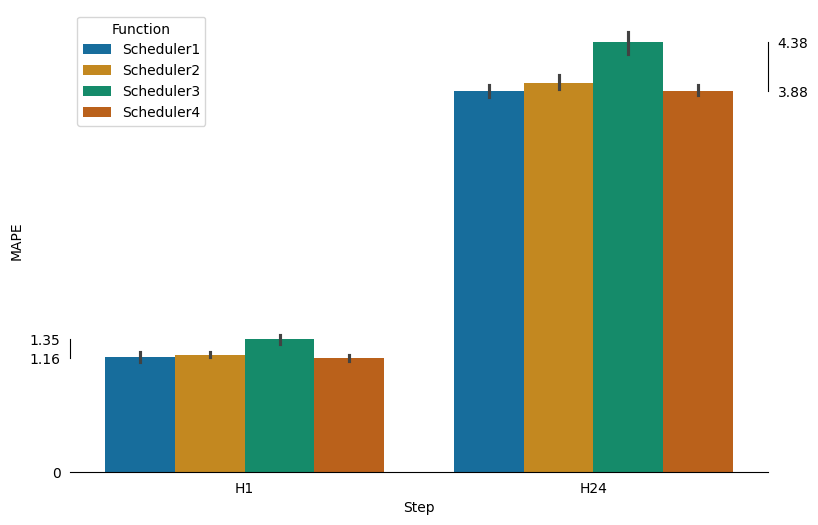

In [156]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(data=lr_smry_df, x='Step', y='MAPE', hue='function', palette=palette(lr_smry_df.function.nunique()))

h1_means = lr_smry_df[lr_smry_df.Step == 'H1'].groupby(['function']).MAPE.mean()
neaten_ticks(ax, 'y', [h1_means.min(), h1_means.max()], [0], dp=2)

ax2 = ax.twinx()
h24_means = lr_smry_df[lr_smry_df.Step == 'H24'].groupby(['function']).MAPE.mean()
neaten_ticks(ax2, 'y', [h24_means.min(), h24_means.max()], [], dp=2, twin=True)
ax2.set_ylim(*ax.get_ylim())

ax.tick_params(axis='both', color='white')
ax2.tick_params(axis='both', color='white')

show(fig, [ax, ax2], delax=False, despine_twin=True)


In [160]:
from scipy.stats import ttest_ind

for stp in lr_smry_df.Step.unique():
    x = lr_smry_df[(
        (lr_smry_df.function.isin(['scheduler4']))
        & (lr_smry_df.Step == stp)
    )].MAPE
    y = lr_smry_df[(
        (lr_smry_df.function.isin(['scheduler2']))
        & (lr_smry_df.Step == stp)
    )].MAPE
    print(ttest_ind(x, y, equal_var=False, alternative='less').pvalue)


0.09560384352074064
0.0627277513614938


In [247]:
def ci(data: pd.Series, alpha=0.05):
    return norm.ppf(.975) * data.std(ddof=0) / len(data)**.5
    

,mean,ci
0,99.996284,0.004435
1,99.985487,0.005822
2,99.971190,0.008567
3,99.950873,0.013088
4,99.921442,0.020161
...,...,...
1995,2.575270,0.084588
1996,2.574926,0.084592
1997,2.574579,0.084593
1998,2.574236,0.084596


In [420]:
with open('Results/lr scheduler comparison on shallow MLP.json', 'r') as f:
    lr_res = pd.DataFrame(loads(f.read()))

lr_res_df = pd.DataFrame()

for col in lr_res:
    xx = lr_res[col].apply(pd.Series).loss.apply(pd.Series).agg(['mean', ci]).T
    yy = lr_res[col].apply(pd.Series).val_loss.apply(pd.Series).agg(['mean', ci]).T
    for i, zz in enumerate([xx, yy]):
        zz['upper'] = zz['mean'] + zz.ci
        zz['lower'] = zz['mean'] - zz.ci
        zz = zz.drop(columns=['ci'])
        zz['set'] = 'validation' if i else 'train'
        zz['function'] = col
        zz['epoch'] = zz.index + 1
        lr_res_df = pd.concat([lr_res_df, zz]).reset_index(drop=True)
    
lr_res_df


,mean,upper,lower,set,function,epoch
0,99.903358,99.919843,99.886872,train,scheduler1,1
1,99.568192,99.635720,99.500663,train,scheduler1,2
2,98.016785,98.286571,97.746999,train,scheduler1,3
3,94.006918,94.743375,93.270462,train,scheduler1,4
4,86.196698,87.666146,84.727250,train,scheduler1,5
...,...,...,...,...,...,...
15995,2.508362,2.545373,2.471352,validation,scheduler4,1996
15996,2.508346,2.545364,2.471328,validation,scheduler4,1997
15997,2.508301,2.545298,2.471304,validation,scheduler4,1998
15998,2.508275,2.545282,2.471268,validation,scheduler4,1999


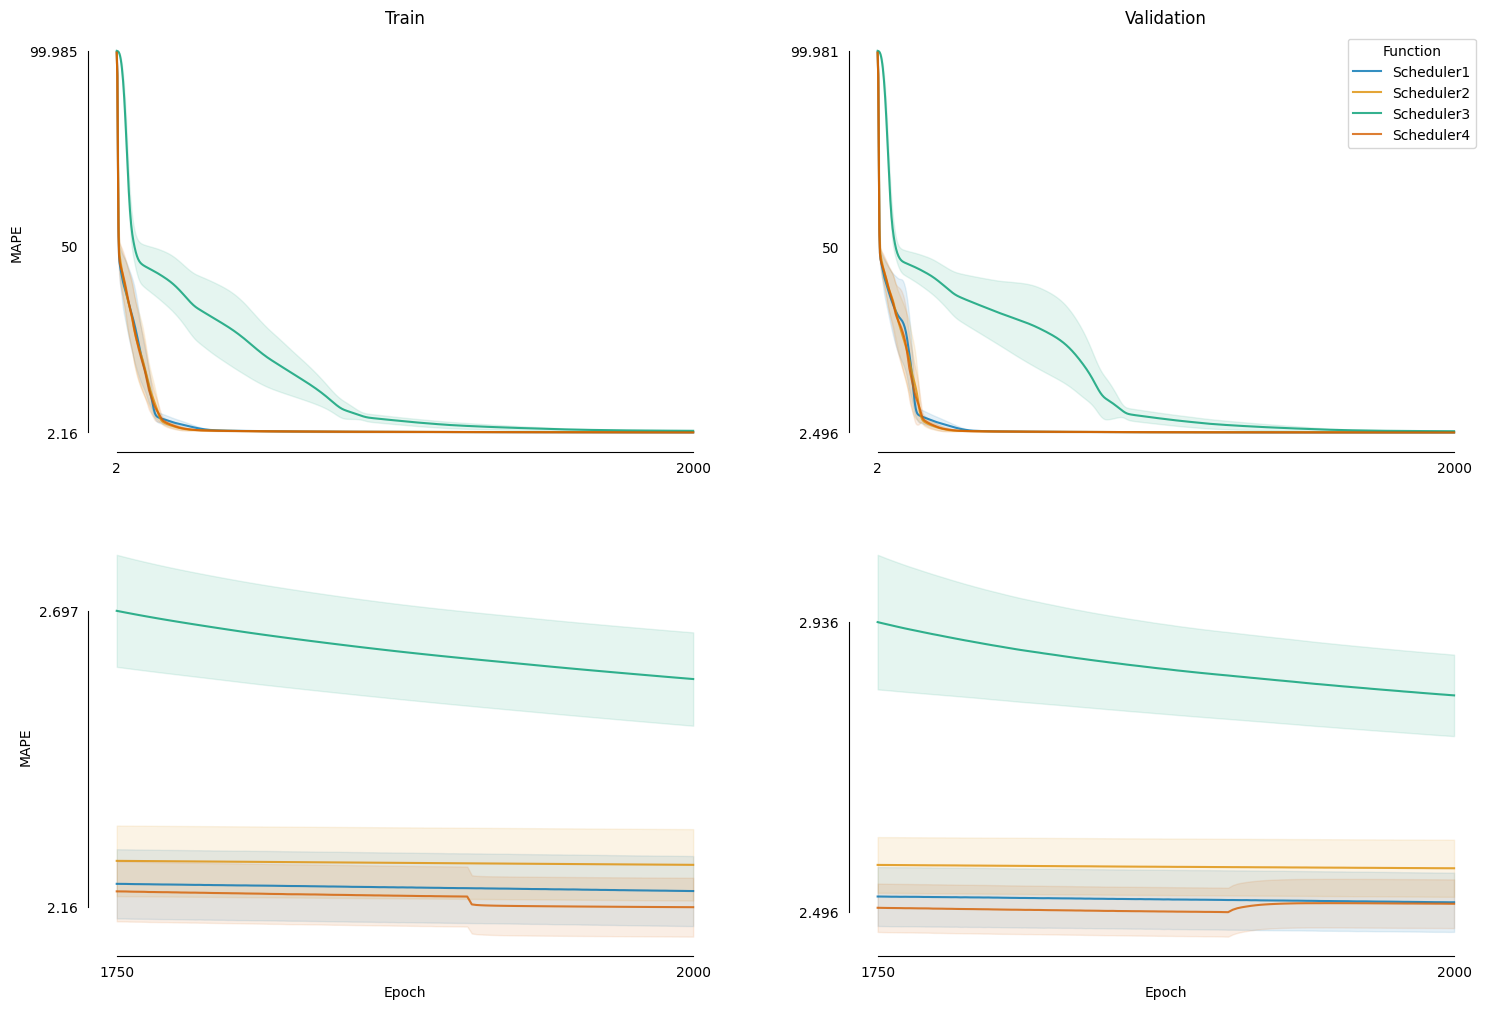

In [414]:
cols = lr_res_df.set.unique()
n_col, n_row = len(cols), 2

fig, axes = plt.subplots(n_row, n_col, figsize=(9*n_col, 6*n_row))
axes = axes.flatten()
fill = palette(lr_res_df.function.nunique())

for i in range(n_col*n_row):
    ax, col = axes[i], cols[i % 2]

    data=lr_res_df[(
        (lr_res_df.set == col)
        & (lr_res_df.index % 2 == 1)
     )]
    if i >= 2:
        yticks = []
        data = data[data.epoch >= 1750]
        title, xlabel, ylabel = '', 'Epoch', ''
    else:
        yticks = [50]
        title, xlabel, ylabel = col.title(), '', ''
    if i % 2 == 0:
        ylabel = 'MAPE'

    sns.lineplot(
        ax=ax, data=data, x='epoch', y='mean', hue='function', 
        palette=fill, alpha=0.8
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for j, fnct in enumerate(data.function.unique()):
        data_f = data[data.function == fnct]
        ax.fill_between(
            data_f.epoch, 
            data_f.upper, 
            data_f.lower, 
            alpha=0.1,
            color=fill[j]
        )

    data_s = data[data.set == col]
    ax.set_yticks([])
    neaten_ticks(ax, 'y', [data_s['mean'].min(), data_s['mean'].max()], yticks, dp=3)
    neaten_ticks(ax, 'x', [data_s.epoch.min(), data_s.epoch.max()], [])

    if i != 1:
        ax.get_legend().remove()
        
    ax.tick_params(axis='both', color='white')

show(fig, axes)


In [404]:
wd_smry_df = pd.read_csv('Results/weight decay comparison on shallow MLP.csv')

wd_smry_df = wd_smry_df.melt(id_vars='weight_decay', var_name='Step', value_name='MAPE')

wd_smry_df


,weight_decay,Step,MAPE
0,0.00000,H1,1.076746
1,0.00000,H1,1.245005
2,0.00000,H1,1.213953
3,0.00000,H1,1.251266
4,0.00000,H1,1.223955
...,...,...,...
75,0.00001,H24,4.104717
76,0.00001,H24,4.071819
77,0.00001,H24,4.041662
78,0.00001,H24,3.816740


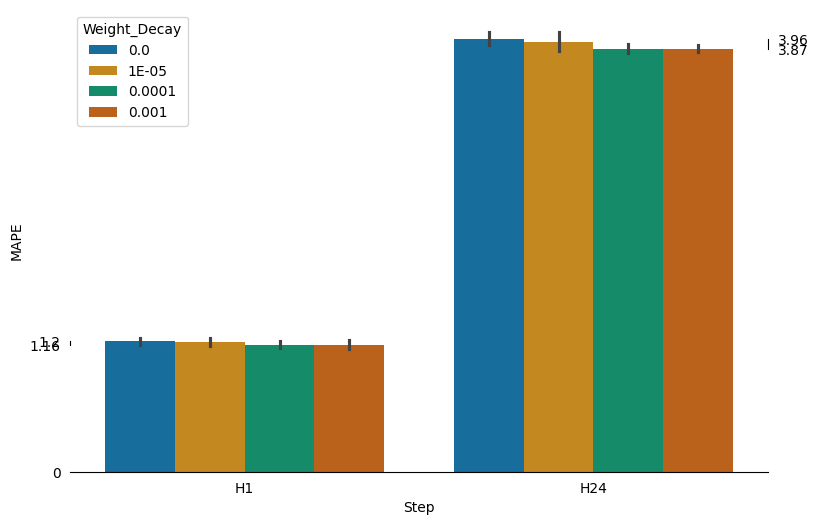

In [412]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(data=wd_smry_df, x='Step', y='MAPE', hue='weight_decay', palette=palette(wd_smry_df.weight_decay.nunique()))

h1_means = wd_smry_df[wd_smry_df.Step == 'H1'].groupby(['weight_decay']).MAPE.mean()
neaten_ticks(ax, 'y', [h1_means.min(), h1_means.max()], [0], dp=2)

ax2 = ax.twinx()
h24_means = wd_smry_df[wd_smry_df.Step == 'H24'].groupby(['weight_decay']).MAPE.mean()
neaten_ticks(ax2, 'y', [h24_means.min(), h24_means.max()], [], dp=2, twin=True)
ax2.set_ylim(*ax.get_ylim())

ax.tick_params(axis='both', color='white')
ax2.tick_params(axis='both', color='white')

show(fig, [ax, ax2], delax=False, despine_twin=True)


In [417]:
with open('Results/weight decay comparison on shallow MLP.json', 'r') as f:
    wd_res = pd.DataFrame(loads(f.read()))

wd_res_df = pd.DataFrame()

for col in wd_res:
    xx = wd_res[col].apply(pd.Series).loss.apply(pd.Series).agg(['mean', ci]).T
    yy = wd_res[col].apply(pd.Series).val_loss.apply(pd.Series).agg(['mean', ci]).T
    for i, zz in enumerate([xx, yy]):
        zz['upper'] = zz['mean'] + zz.ci
        zz['lower'] = zz['mean'] - zz.ci
        zz = zz.drop(columns=['ci'])
        zz['set'] = 'validation' if i else 'train'
        zz['weight_decay'] = col
        zz['epoch'] = zz.index + 1
        wd_res_df = pd.concat([wd_res_df, zz]).reset_index(drop=True)
    
wd_res_df


,mean,upper,lower,set,weight_decay,epoch
0,99.895631,99.908109,99.883153,train,null,1
1,99.521867,99.579166,99.464568,train,null,2
2,97.826155,98.100566,97.551744,train,null,3
3,93.352706,94.141577,92.563835,train,null,4
4,85.312503,87.083900,83.541106,train,null,5
...,...,...,...,...,...,...
15995,2.548583,2.598394,2.498771,validation,1e-05,1996
15996,2.548572,2.598394,2.498751,validation,1e-05,1997
15997,2.548541,2.598384,2.498698,validation,1e-05,1998
15998,2.548528,2.598347,2.498710,validation,1e-05,1999


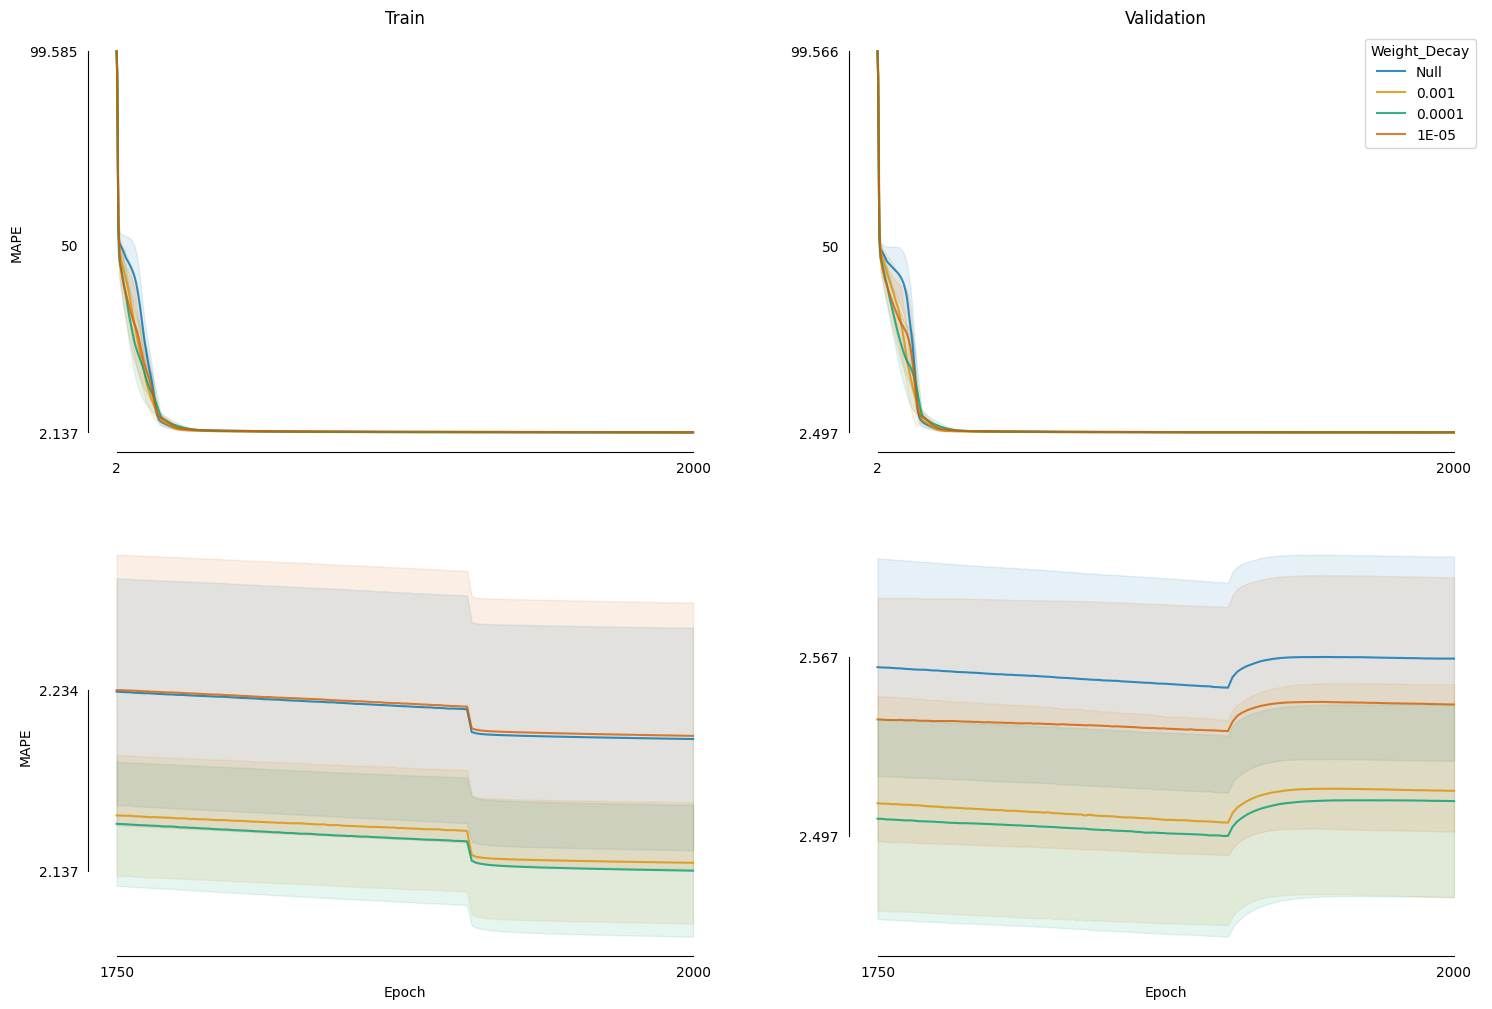

In [418]:
cols = wd_res_df.set.unique()
n_col, n_row = len(cols), 2

fig, axes = plt.subplots(n_row, n_col, figsize=(9*n_col, 6*n_row))
axes = axes.flatten()
fill = palette(wd_res_df.weight_decay.nunique())

for i in range(n_col*n_row):
    ax, col = axes[i], cols[i % 2]

    data=wd_res_df[(
        (wd_res_df.set == col)
        & (wd_res_df.index % 2 == 1)
     )]
    if i >= 2:
        yticks = []
        data = data[data.epoch >= 1750]
        title, xlabel, ylabel = '', 'Epoch', ''
    else:
        yticks = [50]
        title, xlabel, ylabel = col.title(), '', ''
    if i % 2 == 0:
        ylabel = 'MAPE'

    sns.lineplot(
        ax=ax, data=data, x='epoch', y='mean', hue='weight_decay', 
        palette=fill, alpha=0.8
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for j, fnct in enumerate(data.weight_decay.unique()):
        data_f = data[data.weight_decay == fnct]
        ax.fill_between(
            data_f.epoch, 
            data_f.upper, 
            data_f.lower, 
            alpha=0.1,
            color=fill[j]
        )

    data_s = data[data.set == col]
    ax.set_yticks([])
    neaten_ticks(ax, 'y', [data_s['mean'].min(), data_s['mean'].max()], yticks, dp=3)
    neaten_ticks(ax, 'x', [data_s.epoch.min(), data_s.epoch.max()], [])

    if i != 1:
        ax.get_legend().remove()
        
    ax.tick_params(axis='both', color='white')

show(fig, axes)
